In [1]:
!pip install guppy3

## Import modules

In [2]:
import numpy as np
import itertools

# to get and read data
import os
from zipfile import ZipFile
from scipy.io import arff

# to plot the data
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

# for neural network
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [3]:
from google.colab import drive
drive.mount('/content/drive')

os.chdir("/content/drive/MyDrive/project")
from common_modules import data_f, network_f, patches_f, clusters_f
from char_modules import preprocess_f, plotting_f

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import importlib
importlib.reload(clusters_f)

<module 'common_modules.clusters_f' from '/content/drive/MyDrive/project/common_modules/clusters_f.py'>

## get and read data

get data

In [5]:
if not os.path.exists('CharacterTrajectories'):
  # download zip
  data_f.download_file(url = 'http://www.timeseriesclassification.com/Downloads/CharacterTrajectories.zip',
                        saveAs = 'CharacterTrajectories.zip')
  # extract all the contents of zip file in current directory
  with ZipFile('CharacterTrajectories.zip', 'r') as zipObj:
    zipObj.extractall('CharacterTrajectories')
  print('folder extracted from zip')

else:
    print("folder exists")

folder exists


read data

In [6]:
# ignoring metadata at index 1, arff -> (data,meta)
train_data, train_meta = arff.loadarff('CharacterTrajectories/CharacterTrajectories_TRAIN.arff')
test_data, test_meta = arff.loadarff('CharacterTrajectories/CharacterTrajectories_TEST.arff')

train_data = preprocess_f.remove_nan(train_data)
test_data = preprocess_f.remove_nan(test_data)

# subtract 1 to start indexing from 0
train_data = [[input, label - 1] for input,label in train_data]
test_data = [[input, label - 1] for input,label in test_data]

max length = 182


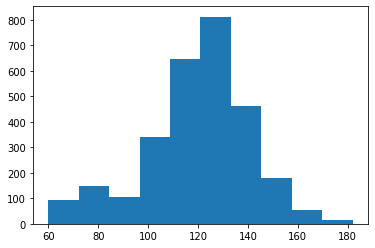

In [7]:
# distribution of sample lenghts
lengths = []

for sample in itertools.chain(train_data,test_data):
  input = sample[0][0]
  input = np.array(input)
  lengths.append(len(input))

print('max length =',np.max(lengths))
_ = plt.hist(lengths)

In [8]:
classes = ['a','b','c','d','e','g','h','l','m','n','o','p','q','r','s','u','v','w','y','z']
print('number of classes :',len(classes))

print('\ntrain data contains',len(train_data),'samples')
print('test data contains',len(test_data),'samples')

print('\neach sample has 3 channels : x,y and force')

number of classes : 20

train data contains 1422 samples
test data contains 1436 samples

each sample has 3 channels : x,y and force


## clustering

In [9]:
train_inputs, train_labels = preprocess_f.resize_samples(train_data,100)

# flatten inputs to 2d array
nsamples, nx, ny = train_inputs.shape
sample_shape = nx, ny
train_inputs = train_inputs.reshape((nsamples,nx*ny))

plot silhoutte index for number of cluster 2 to 20

/usr/local/lib/python3.6/dist-packages/torch/distributed/distributed_c10d.py:126: UserWarning: torch.distributed.reduce_op is deprecated, please use torch.distributed.ReduceOp instead
  warnings.warn("torch.distributed.reduce_op is deprecated, please use "



runtime:  11.899983882904053

memory consumption:
Partition of a set of 1802675 objects. Total size = 138715819 bytes.
 Index  Count   %     Size   % Cumulative  % Kind (class / dict of class)
     0 1029257  57 32936224  24  32936224  24 numpy.float64
     1 205435  11 30257680  22  63193904  46 str
     2 202271  11 16271000  12  79464904  57 tuple
     3  24381   1 10640040   8  90104944  65 list
     4  85456   5  6895740   5  97000684  70 bytes
     5  43574   2  6306008   5 103306692  74 types.CodeType
     6  41386   2  5628496   4 108935188  79 function
     7   4840   0  4798776   3 113733964  82 type
     8  12943   1  4777808   3 118511772  85 dict (no owner)
     9   2130   0  3126456   2 121638228  88 dict of module
<1818 more rows. Type e.g. '_.more' to view.>



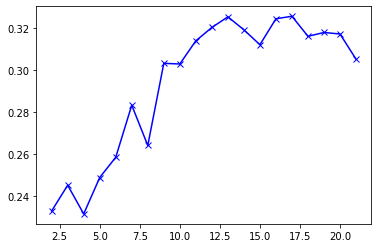

 n_clusters  silhouette     cal_har  dav_bould  adj_rand  adj_mut_inf  v_measure  fowlk_mall
          2    0.232908  423.979819   1.783085  0.083810     0.306534   0.309080    0.293917
          3    0.245155  403.417423   1.578160  0.142532     0.442877   0.446622    0.339162
          4    0.231487  386.491122   1.525203  0.233601     0.537740   0.542035    0.399184
          5    0.248822  363.824199   1.499075  0.278968     0.593291   0.598148    0.430466
          6    0.258476  345.967639   1.360195  0.317913     0.636926   0.642218    0.457622
          7    0.283291  347.876885   1.276758  0.336097     0.654311   0.660287    0.467684
          8    0.264087  331.901126   1.336370  0.426437     0.705596   0.711245    0.527778
          9    0.303210  354.138984   1.189308  0.404993     0.711000   0.717400    0.513371
         10    0.302892  358.062485   1.176078  0.484623     0.748723   0.754790    0.568699
         11    0.313947  359.824744   1.180212  0.538938     0.770611 

In [10]:
_ = clusters_f.form_clusters(train_inputs, "KMeans", list(range(2,22)), train_labels)


runtime:  7.096032381057739

memory consumption:
Partition of a set of 1799008 objects. Total size = 138299318 bytes.
 Index  Count   %     Size   % Cumulative  % Kind (class / dict of class)
     0 1029166  57 32933312  24  32933312  24 numpy.float64
     1 205729  11 30403637  22  63336949  46 str
     2 202110  11 16269672  12  79606621  58 tuple
     3  24102   1 10616744   8  90223365  65 list
     4  85623   5  6915890   5  97139255  70 bytes
     5  43648   2  6316664   5 103455919  75 types.CodeType
     6  41022   2  5578992   4 109034911  79 function
     7   4846   0  4805568   3 113840479  82 type
     8  12486   1  4676592   3 118517071  86 dict (no owner)
     9   2136   0  3133048   2 121650119  88 dict of module
<1735 more rows. Type e.g. '_.more' to view.>



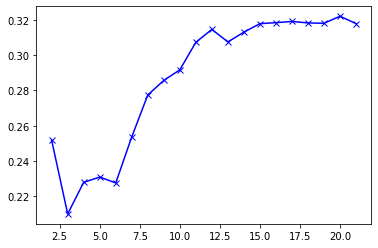

 n_clusters  silhouette     cal_har  dav_bould  adj_rand  adj_mut_inf  v_measure  fowlk_mall
          2    0.251687  331.689990   1.417333  0.041007     0.262624   0.265531    0.264786
          3    0.209996  349.780105   1.723966  0.151336     0.478016   0.481541    0.353254
          4    0.227895  319.393502   1.476209  0.182378     0.538422   0.542994    0.376792
          5    0.230879  307.915187   1.459246  0.226330     0.603279   0.608255    0.407877
          6    0.227534  307.556096   1.497131  0.347831     0.688989   0.693550    0.493214
          7    0.253625  311.848083   1.399329  0.373847     0.718793   0.723660    0.511205
          8    0.277412  320.722633   1.262321  0.386544     0.738101   0.743365    0.519972
          9    0.285628  327.261606   1.218627  0.446887     0.775959   0.780951    0.561652
         10    0.291641  336.530201   1.243826  0.513094     0.789770   0.794871    0.600930
         11    0.307252  346.129832   1.197073  0.584826     0.820059 

In [11]:
_ = clusters_f.form_clusters(train_inputs, "AgglomerativeClustering", list(range(2,22)), train_labels)


runtime:  16.199673414230347

memory consumption:
Partition of a set of 1887547 objects. Total size = 155806238 bytes.
 Index  Count   %     Size   % Cumulative  % Kind (class / dict of class)
     0 228614  12 33283239  21  33283239  21 str
     1 1029186  55 32933952  21  66217191  42 numpy.float64
     2 221183  12 17612296  11  83829487  54 tuple
     3  25785   1 10912536   7  94742023  61 list
     4  93241   5  7383487   5 102125510  66 bytes
     5  19125   1  6969000   4 109094510  70 dict (no owner)
     6  47361   3  6852912   4 115947422  74 types.CodeType
     7  44876   2  6103136   4 122050558  78 function
     8   5668   0  5521848   4 127572406  82 type
     9    332   0  5280737   3 132853143  85 numpy.ndarray
<2264 more rows. Type e.g. '_.more' to view.>



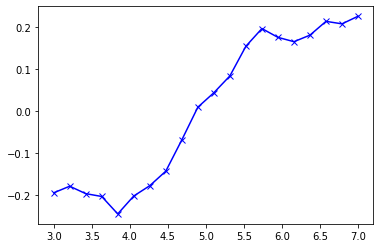

      eps  num_clusters  silhouette     cal_har  dav_bould  adj_rand  adj_mut_inf  v_measure  fowlk_mall
 3.000000             2   -0.195182    5.532190   2.263534  0.000346     0.024805   0.029780    0.221401
 3.210526             2   -0.179406    9.460621   2.324900  0.001876     0.048056   0.052770    0.222091
 3.421053             4   -0.197145   12.819451   2.116530  0.009161     0.142075   0.153873    0.224640
 3.631579             5   -0.203911   15.081832   1.978290  0.013442     0.186034   0.200252    0.226548
 3.842105             7   -0.245571   19.043799   1.905932  0.022912     0.262783   0.280906    0.231723
 4.052632             7   -0.202770   24.880085   1.952798  0.034140     0.323688   0.339782    0.242158
 4.263158             7   -0.178148   29.182803   1.986282  0.044561     0.366179   0.380852    0.253827
 4.473684            12   -0.143424   34.830250   1.892805  0.075100     0.485695   0.505027    0.267216
 4.684211            15   -0.068746   42.167414   1.844

In [70]:
_ = clusters_f.form_clusters(train_inputs, "DBSCAN", np.linspace(3,7,20) , train_labels)


runtime:  136.01023721694946

memory consumption:
Partition of a set of 1895716 objects. Total size = 153880926 bytes.
 Index  Count   %     Size   % Cumulative  % Kind (class / dict of class)
     0 234584  12 33830395  22  33830395  22 str
     1 1029202  54 32934464  21  66764859  43 numpy.float64
     2 221246  12 17616864  11  84381723  55 tuple
     3  26110   1 11019688   7  95401411  62 list
     4  93345   5  7392269   5 102793680  67 bytes
     5  19999   1  7323792   5 110117472  72 dict (no owner)
     6  47361   2  6852912   4 116970384  76 types.CodeType
     7  44882   2  6103952   4 123074336  80 function
     8   5668   0  5521848   4 128596184  84 type
     9   2363   0  3421312   2 132017496  86 dict of module
<2267 more rows. Type e.g. '_.more' to view.>



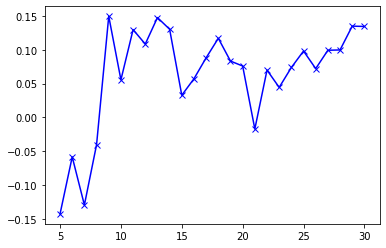

 min_samples  num_clusters  silhouette     cal_har  dav_bould  adj_rand  adj_mut_inf  v_measure  fowlk_mall
           5            21   -0.142491   49.950617   1.519403  0.153947     0.613192   0.634432    0.331038
           6            16   -0.058269   74.191232   1.632729  0.195669     0.676558   0.690610    0.369472
           7            20   -0.129297   57.253751   1.510968  0.162120     0.625996   0.646268    0.338667
           8            15   -0.040243   89.165665   1.482234  0.174699     0.649863   0.664357    0.350744
           9            14    0.149462  179.956796   1.332471  0.332597     0.759453   0.768162    0.463284
          10            12    0.055584  130.719795   1.402310  0.178518     0.655019   0.666607    0.354807
          11            13    0.129693  167.843240   1.368815  0.252232     0.720931   0.730670    0.408041
          12            12    0.108390  155.443905   1.372359  0.210232     0.686545   0.696842    0.378148
          13            11  

In [87]:
_ = clusters_f.form_clusters(train_inputs, "OPTICS", list(range(5,31)), train_labels)

### visualize cluster centers


runtime:  0.7480812072753906

memory consumption:
Partition of a set of 1959206 objects. Total size = 309858373 bytes.
 Index  Count   %     Size   % Cumulative  % Kind (class / dict of class)
     0    344   0 151489035  49 151489035  49 numpy.ndarray
     1 290655  15 38913532  13 190402567  61 str
     2 1031893  53 33020576  11 223423143  72 numpy.float64
     3 221621  11 17650736   6 241073879  78 tuple
     4  26937   1 11697896   4 252771775  82 list
     5  21547   1  7902712   3 260674487  84 dict (no owner)
     6  93495   5  7398715   2 268073202  87 bytes
     7  47379   2  6855504   2 274928706  89 types.CodeType
     8  44909   2  6107624   2 281036330  91 function
     9   5671   0  5526008   2 286562338  92 type
<2270 more rows. Type e.g. '_.more' to view.>

 num_clusters  silhouette     cal_har  dav_bould  adj_rand  adj_mut_inf  v_measure  fowlk_mall
           17    0.324618  320.941778   1.228732  0.767554     0.872264   0.877329    0.785159

cluster centers visual

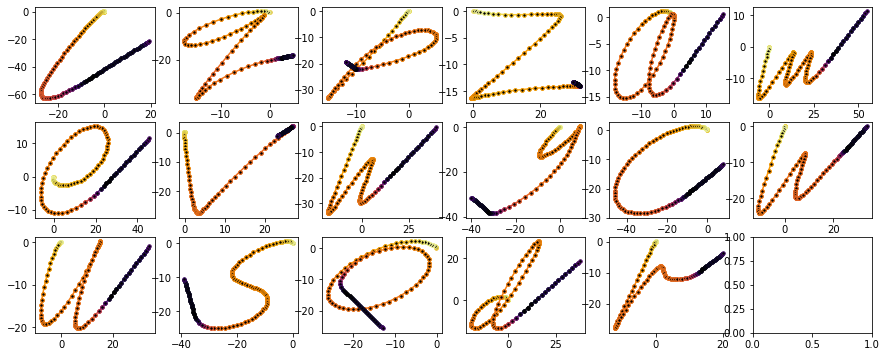

In [ ]:
cluster_centers = clusters_f.form_clusters(train_inputs, "KMeans", [17], train_labels)

print("\ncluster centers visualized")
plotting_f.plotClusters(cluster_centers, sample_shape)

## patches

In [ ]:
kwargs = {'window_size':20, 'stride':10, 'resizeTo':100, 'medianFilter':True, 'gaussianFilter':True, 'normalize':(-1,1)}

kwargs['data'] = train_data
train_inputs, train_labels, train_indexes = patches_f.dataToPatches(**kwargs)
kwargs['data'] = test_data
test_inputs, test_labels, test_indexes = patches_f.dataToPatches(**kwargs)

create dataset and dataloader

In [ ]:
train_loader, val_loader, test_loader = data_f.createLoaders(train_inputs, train_labels,
                                                                  test_inputs, test_labels,
                                                                  batch_size=32)

### visualize patches

a
original sample


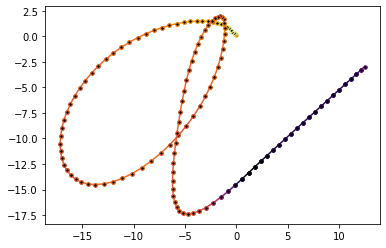

11 patches


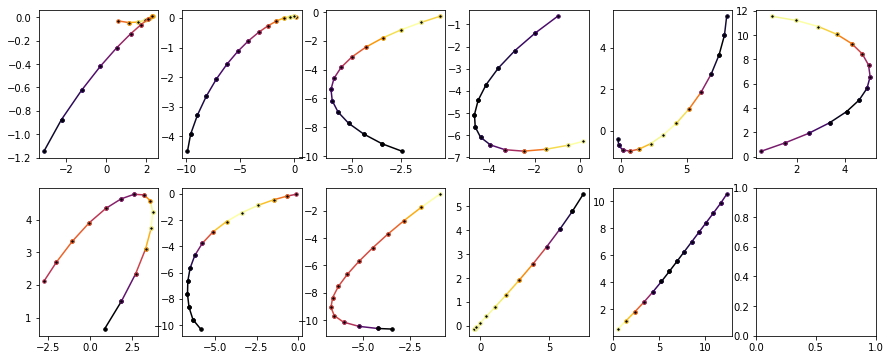

In [ ]:
plotting_f.plotChar(train_data, train_indexes, train_inputs, char='a')

## neural network

### define network

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # 4 input channels, 6 output channels, row convolution kernel of size 3
        self.conv1 = nn.Conv1d(4, 6, 3)
        self.conv2 = nn.Conv1d(6, 16, 3)
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(368, 120) 
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 20)

    def forward(self, x):
        # output given by : math.floor((inp-(k-1)-1)/s+1)
        x = F.max_pool1d(F.relu(self.conv1(x)), 2)
        x = F.max_pool1d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

### create network

In [ ]:
net = Net().to(device)

#Define a Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

### train network

epoch: 15, train loss: 1.687, val loss: 1.711
epoch: 30, train loss: 0.989, val loss: 1.076
epoch: 45, train loss: 0.790, val loss: 0.896
epoch: 60, train loss: 0.671, val loss: 0.843
epoch: 75, train loss: 0.598, val loss: 0.841
epoch: 90, train loss: 0.533, val loss: 0.828
epoch: 105, train loss: 0.486, val loss: 0.793
epoch: 120, train loss: 0.453, val loss: 0.909
epoch: 135, train loss: 0.414, val loss: 0.854
epoch: 150, train loss: 0.386, val loss: 0.861

Finished Training


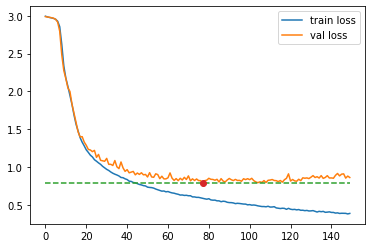

In [ ]:
best_params = network_f.trainNet(net,criterion,optimizer, 
                                  train_loader,val_loader,
                                  epochs=150)

In [ ]:
net.load_state_dict(best_params)

<All keys matched successfully>

### evaluate network

In [ ]:
print("evaluation results on train data")
network_f.evaluate(net,train_loader,classes)
print("evaluation results on test data")
network_f.evaluate(net,test_loader,classes)

evaluation results on train data



              precision    recall  f1-score   support

           a     0.7891    0.7632    0.7759       760
           b     0.6301    0.7929    0.7022       623
           c     0.9683    0.9735    0.9709       377
           d     0.9141    0.7800    0.8418       641
           e     0.9295    0.9606    0.9448       686
           g     0.7989    0.7080    0.7507       589
           h     0.6878    0.5872    0.6335       499
           l     0.9944    0.9781    0.9862       365
           m     0.8000    0.9231    0.8571       611
           n     0.7244    0.5380    0.6174       474
           o     0.9077    0.8817    0.8945       524
           p     0.6974    0.6926    0.6950       579
           q     0.9151    0.8744    0.8943       629
           r     0.7727    0.5690    0.6554       478
           s     0.7840    0.9193    0.8463       545
           u     0.6339    0.6736    0.6532       527
           v     0.9786    0.9786    0.9786       513
           w     0.5120   


              precision    recall  f1-score   support

           a     0.6966    0.6520    0.6736      1000
           b     0.5606    0.7090    0.6261       842
           c     0.9117    0.9473    0.9291       512
           d     0.8508    0.7585    0.8020       857
           e     0.8808    0.9033    0.8919       900
           g     0.6570    0.5500    0.5987       780
           h     0.5712    0.4954    0.5306       656
           l     0.9824    0.9084    0.9439       491
           m     0.7263    0.8005    0.7616       812
           n     0.5823    0.4175    0.4863       661
           o     0.8278    0.8588    0.8430       694
           p     0.6036    0.6130    0.6082       770
           q     0.8270    0.8369    0.8319       834
           r     0.6897    0.4791    0.5654       645
           s     0.7809    0.8776    0.8264       727
           u     0.5255    0.5755    0.5494       735
           v     0.9171    0.9345    0.9257       687
           w     0.4306   